In [1]:
import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import onnx
from onnx2pytorch import ConvertModel
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

from vnnlib.compat import read_vnnlib_simple
from collections import OrderedDict

# Import the Feedforward-NN
It has to bee a SequentialNN

In [3]:

"""nn = SequentialNN([28 * 28 * 1, 100, 30, 10])
nn.load_state_dict(torch.load("../../mnist_fc.pth", map_location=torch.device(device)), strict=False)"""


"""
nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc_6x256.pth", map_location=torch.device('cpu')), strict=False)
"""


"""nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc 4x256.pth", map_location=torch.device("cpu")), strict=False)"""



'nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])\nnn.load_state_dict(torch.load("../../mnist_fc 4x256.pth", map_location=torch.device("cpu")), strict=False)'

#### or make onnx to Sequential

In [4]:
onnx_model = onnx.load("mnist-net_256x4.onnx")
pytorch_model = ConvertModel(onnx_model)

nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])
state_dict = pytorch_model.state_dict()
my_state_dict = {}
for i, key in enumerate(state_dict):
    actual_index = i * 2
    my_state_dict[f"{actual_index}.bias"] = state_dict[f"_initializer_layers_{actual_index}_bias"]
    my_state_dict[f"{actual_index}.weight"] = state_dict[f"_initializer_layers_{actual_index}_weight"]
    if actual_index == 8:
        break
    
nn.load_state_dict(my_state_dict)

/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


<All keys matched successfully>

In [5]:
parameter_list = list(nn.parameters())
output_size = 10
number_layer = (len(parameter_list) - 2) // 2

# Load the data to apply the verification process for

In [6]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.to("cpu").numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [7]:
transform = Compose([ToTensor()])
training_data = MNIST(root="../../mnist", train=True, download=True, transform=transform)

# Settings for the optimization 

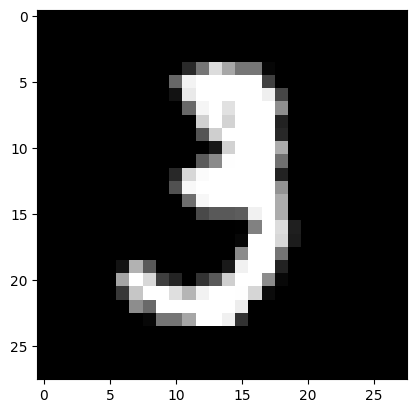

The label is 3
NN classifies image correctly as 3


In [8]:
# image to do the verification for
image_index = 10

# epsilon radius
eps = 0.03

# whether a verification attempt should be done using just MILP encoding for comparison (can take long)
use_milp = False

image, label = training_data[image_index]
torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
imshow(torch_image[0][0])
print(f"The label is {label}")

if torch.argmax(nn(torch_image)).item() == label:
    print("NN classifies image correctly as {}".format(label))
else:
    print("NN classifies image wrong")


In [9]:
total_correct = 0
total_wrong = 0
do_test = False
if do_test:
    for image, label in training_data:
        torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
        if torch.argmax(nn(torch_image)).item() == label:
            total_correct += 1
        else:
            total_wrong += 1
            
        print(total_correct, total_wrong)
    print(f"accuracy {total_correct/ len(training_data)}")


# Add the objective to the optimization problem
in this case we want to find the maximum difference between any one neuron and the target neuron (label)

In [10]:
def add_output_constraints(model, nn_layer_out_bounds, label, output_vars, sovler_bound=1e-3):
    """
    
    :param model: the optimization problem in gurobi encoding the NN
    :param nn_layer_out_bounds: torch.Tensor, approximating the upper and lower bounding the output layer of the NN
    :param label: index of the label or target neuron which is compared against
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :param sovler_bound: provides a bound for the gurobi solver. If this bound is achieved, the optimizer stops
    """
    
    out_lb = nn_layer_out_bounds[-1][0].detach().cpu().numpy()
    out_ub = nn_layer_out_bounds[-1][1].detach().cpu().numpy()
    
    difference_lb = out_lb - out_ub[label]
    difference_ub = out_ub - out_lb[label]
    difference_lb = difference_lb.tolist()
    difference_ub = difference_ub.tolist()
    
    difference_lb.pop(label)
    difference_ub.pop(label)
    
    min_diff = min(difference_lb)
    max_diff = max(difference_ub)
    
    difference = model.addVars(9, lb=difference_lb, ub=difference_ub, name="diff_var")
    model.addConstrs((difference[i] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(0, label)), name="diff_const0")
    model.addConstrs((difference[i - 1] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(label + 1, 10)), name="diff_const1")

    max_var = model.addVar(lb=min_diff, ub=max_diff, name="max_var")
    model.addConstr(max_var == grp.max_(difference))

    if sovler_bound != None:
        model.setParam("BestObjStop", sovler_bound)

    model.update()
    model.setObjective(max_var, grp.GRB.MAXIMIZE)

# Get the output variables by name 
given the gurobi model, the output size of the NN and the index of output layer

In [11]:
def get_output_vars_snv_milp(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("affine_var{}[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

In [12]:
def get_output_vars_dhov(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("output_layer_[{}]_[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

# Defining function to call Gurobi optimizer

In [13]:
def optimize_model(model, output_vars):
    """
    
    :param model: the optimization problem in gurobi encoding the NN and the objective 
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :return True if verification was successful, else false 
    """
    
    start = time.time()
    model.update()
    model.optimize()
    
    if model.Status == grp.GRB.OPTIMAL or model.Status == grp.GRB.USER_OBJ_LIMIT:
        
        for i, var in enumerate(output_vars.tolist()):
            print("var {}: {}".format(i, var.getAttr("x")))
        max_var = model.getVarByName("max_var").getAttr("x")
        
        if max_var < 0:
            print("property verified with max difference {}".format(max_var))
            return True
        else:
             print("property NOT verified with max difference {}".format(max_var))
             return False

    elif model.Status == grp.GRB.INFEASIBLE:
        print("model infeasible")

        model.computeIIS()
        print("constraint")
        all_constr = model.getConstrs()

        for const in all_constr:
            if const.IISConstr:
                print("{}".format(const))

        print("lower bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISLB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

        print("upper bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISUB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

    print("time to optimize: {}".format(time.time() - start))
    return False

# Calculate box-bounds to provide a rough approximation of NN

In [14]:
input_flattened = torch.flatten(torch_image)
simple_bounds_affine_out, simple_bounds_layer_out = nn.calculate_box_bounds([input_flattened.add(-eps), input_flattened.add(eps)])
print(simple_bounds_affine_out[-1][0].tolist())
print(simple_bounds_affine_out[-1][1].tolist())


[-1032.553494946478, -872.9257565705025, -1141.959246872821, -1203.297658206732, -1105.71108391385, -986.7314910178, -954.3195523478022, -1036.1493852084127, -1236.6732217595502, -945.4201504345255]
[822.8642229269997, 734.7687204634503, 739.7653141953177, 644.5772098039624, 858.5091913462222, 782.4145591124344, 917.3556478411418, 876.5302067990469, 868.9227335602428, 935.6565249544531]


# Do Single-Neuron-Verification

In [15]:
use_snv = False
if use_snv:
    t = time.time()
    
    # define the Verifier
    snv_verifier = SingleNeuronVerifier(nn, torch_image, eps, print_log=False, print_new_bounds=True, optimize_bounds=True)
    
    # generate the constraints
    snv_verifier.generate_constraints_for_net()
    snv_model = snv_verifier.model
    snv_model.update()
    
    # add the objective to the gurobi model
    snv_out_vars = get_output_vars_snv_milp(snv_model, output_size, number_layer * 2)
    add_output_constraints(snv_model, simple_bounds_layer_out, label, snv_out_vars, sovler_bound=None)
    print("constraint generation time: {}".format(time.time() - t))
    
    print("start with optimization")
    optimize_model(snv_model, snv_out_vars)

 # Do MILP-Verification if wanted

In [16]:
if use_milp:
    # define the Verifier
    milp_verifier = MILPVerifier(nn, torch_image, eps, print_log=False)
    
    # generate the constraints
    milp_verifier.generate_constraints_for_net()
    milp_model = milp_verifier.model
    milp_model.update()
    
    # add the objective to the gurobi model
    milp_out_vars = get_output_vars_snv_milp(milp_model, output_size, number_layer * 2)
    add_output_constraints(milp_model, simple_bounds_layer_out, label, milp_out_vars)
    
    print("start with optimization")
    optimize_model(milp_model, milp_out_vars)

# get bounds with crown

In [17]:
def load_onnx_model(onnx_path, input_shape):
    onnx_model = onnx.load(onnx_path)
    torch_model = ConvertModel(onnx_model)
    
    x_concrete = torch.zeros(input_shape)
    model = BoundedModule(torch_model, x_concrete)
    return model

In [18]:
def load_vnnlib_spec(vnnlib_path, input_shape, n_out):
    n_in = np.prod(input_shape)
    res = read_vnnlib_simple(vnnlib_path, n_in, n_out)
    bnds, spec = res[0]
    
    bnds = np.array(bnds)
    lbs = bnds[:,0]
    ubs = bnds[:,1]
    
    data_min = torch.tensor(lbs, dtype=torch.float32).reshape(input_shape)
    data_max = torch.tensor(ubs, dtype=torch.float32).reshape(input_shape)
    center = 0.5*(data_min + data_max)

    ptb = PerturbationLpNorm(x_L=data_min, x_U=data_max)
    x = BoundedTensor(center, ptb)
    
    return x

In [19]:
onnx_path = 'mnist-net_256x4.onnx'
vnnlib_path = 'prop_0_0.03.vnnlib'

In [20]:
model = load_onnx_model(onnx_path, [1,1,1,784])
x = load_vnnlib_spec(vnnlib_path, [1,1,1,784], 10)

/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/onnx2pytorch/convert/model.py:163: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not self.experimental and inputs[0].shape[self.batch_dim] > 1:
/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/auto_LiRPA/parse_graph.py:154: FutureWarning: 'torch.onnx.symbolic_helper._set_opset_version' is deprecated in version 1.13 and will be removed in 2.0. Please remove its usage and avoid setting internal variables directly.
  _set_opset_version(12)
/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/vnnlib/compat.py:283: UserWarning: literal negation does not strictly follow SMT-LIB
  ast_node = parse_file(vnnlib_filename, strict=False)


In [21]:
def get_layers(model):
    return [l for l in model.nodes() if l.perturbed]

In [22]:
def get_intermediate_bounds(model):
    """
    Returns a dictionary containing the concrete lower and upper bounds of each layer.
    
    Implemented own method to filter out bounds for weight matrices.
    
    Only call this method after compute_bounds()!
    """
    od = OrderedDict()
    for l in get_layers(model):
        if hasattr(l, 'lower'):
            od[l.name] = (l.lower, l.upper)
            
    return od

In [23]:
model.compute_bounds(x=(x,), method='ibp')
model.compute_bounds(x=(x,), method='crown')

(tensor([[-16.1574, -13.2932, -17.4020, -26.5492, -17.5962, -16.9601, -15.3861,
          -17.6454, -20.9628, -15.7071]], grad_fn=<ViewBackward0>),
 tensor([[13.8042, 12.8868, 11.2402,  7.7739, 14.1580, 12.1219, 15.4775, 13.8468,
          12.8768, 15.7155]], grad_fn=<ViewBackward0>))

In [24]:
bounds_dict_crown = get_intermediate_bounds(model)

In [25]:
bounds_dict_crown.keys()
crown_bounds_affine_out = []
for i, key in enumerate(bounds_dict_crown.keys()):
    print(key)
    if i == 0: # use this if ibp is used (or i % 2 == 1:)
        continue
    lb, ub = bounds_dict_crown[key]
    crown_bounds_affine_out.append([lb.type(data_type).view(-1).to(device), ub.type(data_type).view(-1).to(device)])



/0
/input
/input.3
/input.7
/input.11
/30


In [26]:
crown_bounds_layer_out = []
relu = torch.nn.ReLU()
for i, (lb, ub) in enumerate(crown_bounds_affine_out):
    if i == len(crown_bounds_affine_out) - 1:
        crown_bounds_layer_out.append([lb, ub])
    else:
        lb_layer = relu(lb)
        ub_layer = relu(ub)
        crown_bounds_layer_out.append([lb_layer, ub_layer])

In [27]:
print(crown_bounds_affine_out[-1][0])

tensor([-16.1574, -13.2932, -17.4020, -26.5492, -17.5962, -16.9601, -15.3861,
        -17.6454, -20.9628, -15.7071], dtype=torch.float64,
       grad_fn=<ViewBackward0>)


In [28]:
print(simple_bounds_affine_out[2][0])

tensor([-186.3934, -166.1222, -133.4717, -167.3497, -141.4671, -291.8646,
        -145.1084, -152.4255, -105.8477, -119.2242, -158.8032, -335.8949,
        -126.8841, -106.2285, -100.5970, -144.9053, -128.5827, -216.1721,
        -104.5580, -176.2673, -241.1868, -135.9195, -116.9115, -149.1140,
        -172.8038, -109.1280, -167.3485, -276.8488, -105.1384, -172.5290,
        -128.1274, -281.1724, -120.7568, -179.6152, -190.0453, -197.2409,
        -175.8437, -137.7844,  -88.1701, -168.7748, -128.0328, -165.3708,
        -175.1400, -227.6097, -131.5107, -129.4821, -113.5110, -127.5611,
        -223.4063, -121.9744, -151.3296, -150.1186, -121.7823, -129.9400,
        -190.6910, -152.7667, -126.3819, -123.5460, -159.6351, -241.9066,
        -114.8181, -288.5023, -137.2866, -112.5156, -162.7558, -157.9243,
        -237.5894, -131.1929, -186.1840, -109.7676, -165.9870, -158.3168,
        -300.4587, -124.3646, -362.5540, -122.0489,  -99.1765, -143.4968,
        -151.3960, -114.2471, -112.773

In [29]:
snv_affine_out, snv_layer_out = snv_verifier.bounds_affine_out, snv_verifier.bounds_layer_out

NameError: name 'snv_verifier' is not defined

In [30]:
print(snv_affine_out[-1][1])

NameError: name 'snv_affine_out' is not defined

In [31]:
for (lb_crown, ub_crown), (lb_simple, ub_simple) in zip(crown_bounds_affine_out, simple_bounds_affine_out):
    print(torch.isclose(lb_crown, lb_simple).all())
    print(torch.isclose(ub_crown, ub_simple).all())
    print("===============")

tensor(True)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)


# Attempt verification using DHOV
See MultiDHOV.py and ICNNFactory.py for detailed documentation about the parameters

In [32]:
from script.DHOV.Sampling.PerGroupLineSearchSampling import PerGroupLineSearchSamplingStrategy
from script.DHOV.Sampling.PerGroupSamplingStrategy import PerGroupSamplingStrategy
center = torch.flatten(torch_image)
sampling_strategy = PerGroupLineSearchSamplingStrategy(center, eps, nn, keep_ambient_space=True, sample_new=False, sample_count=10000)
# number of neurons which are in one group
group_size = 20

# method of sampling data points
#sampling_method = "per_group_sampling"

# Size of each layer of the ICNN except for the input layer. (given by group size)
net_size = [5, 1]

# picking the typ of ICNN to use
#icnn_factory = ICNNFactory("approx_max", net_size, maximum_function="SMU", function_parameter=0.3)
icnn_factory = ICNNFactory("logical", net_size, always_use_logical_layer=False)
#icnn_factory = ICNNFactory("standard", net_size, adapt_layer_for_init=True)

bounds_affine_out_snr, bounds_layer_out_snr = crown_bounds_affine_out, crown_bounds_layer_out

overall_time = time.time()
dhov_verifier = multidhov.MultiDHOV()
dhov_verifier.start_verification(nn, torch_image, icnn_factory, group_size, eps=eps, icnn_epochs=200,
                                 init_affine_bounds=bounds_affine_out_snr, init_layer_bounds=bounds_layer_out_snr,
                                 icnn_batch_size=10000, use_over_approximation=True, break_after=None,
                                 tighten_bounds=False, 
                                 use_fixed_neurons_in_grouping=False, layers_as_snr=[], layers_as_milp=[3],
                                 force_inclusion_steps=3, preemptive_stop=True,
                                data_grad_descent_steps=0, opt_steps_gd=100,
                                 train_outer=False, print_training_loss=False, print_new_bounds=False,
                                 grouping_method="consecutive", group_num_multiplier=5, store_samples=False, print_optimization_steps=False, print_last_loss=False,
                                 should_plot="none", optimizer="SdLBFGS", init_network=True, adapt_lambda="included", sampling_strategy=sampling_strategy)
print("overall time: {}".format(time.time() - overall_time))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-14


/home/ufuk/Documents/Programming/ICNN_verification/script/DHOV/Sampling/PerGroupLineSearchSampling.py:19: UserWarning: keep_ambient_space is True and sampling method is per_group_sampling. Keeping previous samples is not supported when using per group sampling
  warnings.warn("keep_ambient_space is True and sampling method is per_group_sampling. "
/home/ufuk/Documents/Programming/ICNN_verification/script/DHOV/MultiDHOV.py:188: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "



approximation of layer: 0
    number of fixed neurons for current layer: 202
        time for sampling: 0.9501633644104004
    layer progress, group 1 of 3 


/home/ufuk/Documents/Programming/ICNN_verification/script/Optimizer/sdlbfgs.py:83: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))
/home/ufuk/Documents/Programming/ICNN_verification/script/NeuralNets/Networks.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.data = b - torch.tensor(value, device=device)


        time for training: 10.628385305404663
        actual verification time 0.6850028038024902
        time for verification: 0.7169051170349121
    layer progress, group 2 of 3 
        time for training: 10.871278524398804
        actual verification time 0.24419403076171875
        time for verification: 0.27588391304016113
    layer progress, group 3 of 3 
        time for training: 11.258182287216187
        actual verification time 0.1515347957611084
        time for verification: 0.17595505714416504

approximation of layer: 1
    number of fixed neurons for current layer: 164
        time for sampling: 33.567941665649414
    layer progress, group 1 of 5 
        time for training: 20.01220679283142
        actual verification time 0.8050930500030518
        time for verification: 0.8378758430480957
    layer progress, group 2 of 5 
        time for training: 15.730262517929077
        actual verification time 0.631234884262085
        time for verification: 0.6631689071655273

# Getting an overview over what DHOV has done
show the neuron groups created by DHOV for each layer by index

In [33]:
for i, groups_in_layer in enumerate(dhov_verifier.all_group_indices):
    print(f"Layer {i}")
    for k, group in enumerate(groups_in_layer):
        print(f"    Group {k}: {group}")

Layer 0
    Group 0: [0, 1, 8, 10, 13, 15, 29, 30, 35, 42, 61, 62, 69, 75, 78, 80, 86, 92, 93, 97]
    Group 1: [114, 120, 127, 134, 137, 146, 156, 166, 172, 175, 176, 177, 178, 179, 182, 187, 188, 190, 194, 195]
    Group 2: [199, 200, 201, 204, 207, 213, 216, 219, 220, 229, 230, 235, 251, 255]
Layer 1
    Group 0: [2, 3, 5, 6, 7, 14, 17, 20, 21, 25, 33, 40, 42, 43, 44, 47, 49, 54, 63, 64]
    Group 1: [65, 67, 69, 70, 71, 72, 74, 75, 76, 79, 80, 82, 83, 92, 93, 94, 95, 96, 100, 101]
    Group 2: [103, 110, 118, 121, 123, 126, 128, 131, 132, 134, 135, 136, 140, 141, 142, 143, 154, 156, 162, 165]
    Group 3: [166, 181, 186, 189, 190, 191, 193, 204, 205, 208, 212, 214, 215, 216, 217, 218, 219, 220, 223, 225]
    Group 4: [233, 234, 237, 239, 240, 241, 242, 243, 246, 248, 252, 254]
Layer 2
    Group 0: [27, 31, 38, 43, 44, 61, 107, 117, 118, 131, 133, 146, 151, 157, 161, 172, 186, 187, 200, 203]
    Group 1: [205, 211, 229, 243, 246]
Layer 3


show the output bounds for the NN. Hopefully these are better than the box-bounds and the bounds obtained by the Single-Neuron-Verification

In [34]:

print(dhov_verifier.bounds_affine_out[-1][0].tolist())
print(dhov_verifier.bounds_affine_out[-1][1].tolist())

[-16.157411575317383, -13.293179512023926, -17.402015686035156, -26.54916000366211, -17.59623908996582, -16.960063934326172, -15.386096954345703, -17.645418167114258, -20.96283721923828, -15.707077026367188]
[13.804232597351074, 12.88681411743164, 11.240226745605469, 7.773935794830322, 14.157960891723633, 12.121850967407227, 15.477540969848633, 13.84675121307373, 12.876795768737793, 15.715452194213867]


# Starting the optimization process

In [35]:
# make changes on a copy of the gurobi model generated by DHOV
dhov_model = dhov_verifier.nn_encoding_model.copy()
dhov_model.update()
dhov_out_vars = get_output_vars_dhov(dhov_model, output_size, number_layer)

In [36]:
add_output_constraints(dhov_model, simple_bounds_layer_out, label, dhov_out_vars, sovler_bound=10)

In [37]:
overall_time = time.time()
optimize_model(dhov_model, dhov_out_vars)
print("overall time: {}".format(time.time() - overall_time))

var 0: 0.125204392417111
var 1: 0.019707263396536084
var 2: 0.04259643624594632
var 3: -0.04030091125113179
var 4: 0.033767361411350685
var 5: -0.12147283351876137
var 6: 0.0718239145502837
var 7: -0.011287063236289044
var 8: -0.028540220342562997
var 9: 1.0932997117190466
property NOT verified with max difference 1.1336006229701785
overall time: 15.77420687675476
